# Mixture of Bernoulli Distributions

## Background

Consider a set of $D$ binary variables $\{x_d\}_{d=1}^D$ such that

$$
    p({\bf x}|\boldsymbol \mu) = \prod_{d=1}^D \mu_d^{x_d}(1 - \mu_d) ^{x_d} 
$$

<strong style="color:crimson">E-Step:</strong>  
Compute the posterior probability distribution considering the _old_ parameters:

$$
    p(z_{\hat k} = 1 | {\bf x}) = \frac{\left[\pi_{\hat k}p({\bf x}|\mu_{\hat k})\right]^{z_{\hat k}}}{\sum_{k=1}^K \pi_kp({\bf x}|\mu_k)}
$$

The expectation of $z_{\hat k}$ is given by

$$
    \mathbb{E}[z_k] = \frac{\pi_{\hat k}p({\bf x}|\mu_{\hat k})}{\sum_{k=1}^K \pi_kp({\bf x}|\mu_k)} =: \gamma(z_k)
$$

<strong style="color:crimson">M-step:</strong>  
Maximize the expectation of the complete-data log-likelihood over the latent posterior distribution $Q$ with respect to the parameters $\boldsymbol\pi$, $\boldsymbol \mu$

$$
    Q = \sum_{n=1}^N\sum_{k=1}^K \gamma(z_{nk})\left[\log \pi_k + \sum_{d=1}^D \left[{\bf x}_{n,d} \log \mu_{k,d} + (1 - {\bf x}_{n,d}) \log(1 - \mu_{k,d})\right] \right]
$$

---

**Note**: In maximizing $Q$ w.r.t. $\mu$ and $\pi$ we are ommiting the effect of the derivative over $\gamma$ –which depends on $\mu$ and $\pi$– since $\gamma$ considers only its _old_ values, which are given constants.

---

Maximizing $Q$ w.r.t. $\pi$ and $\mu$ we arrive at the equations:

$$
\mu_k = \bar{\bf x}_k
$$

$$
    \pi_k = \frac{N_k}{N}
$$

Where

* $N_k = \sum_{n=1}^N \gamma(z_{nk})$
* $\bar{\bf x}_k = \frac{1}{N_k}\sum_{n=1}^N \gamma(z_{nk})x_n$

In [1]:

import numpy as np
import matplotlib.pyplot as plt
from numpy.random import seed, choice, uniform


In [ ]:
import tensorflow as tf

# Load the MNIST dataset
mnist = tf.keras.datasets.mnist

# Split the dataset into training and testing sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Normalize the pixel values to be between 0 and 1
# x_train, x_test = x_train / 255.0, x_test / 255.0

print("MNIST dataset loaded successfully")

NameError: name 'x_train' is not defined

In [3]:
%config InlineBackend.figure_format = "retina"

## The Bernoulli Mixture Model on Digits

In the following example, we use a bernoilli mixture to model handwritten digits.

In [4]:
# (X_train, y_train), (X_test, y_test) = mnist.load_data()

We fit a dataset of $N=600$ digits, compresing the digits `2`, `3`, and `4`, with a mixture of $K=3$ Bernoulli distributions by running 10 iterations of the EM algorithm.

In [11]:
target_ix = (y_train == 2) | (y_train == 3) | (y_train == 4) | (y_train == 5)
# target_ix = y_train > -1
X, y = X_train[target_ix], y_train[target_ix]

X = ((X / 255) > 0.5) * 1.

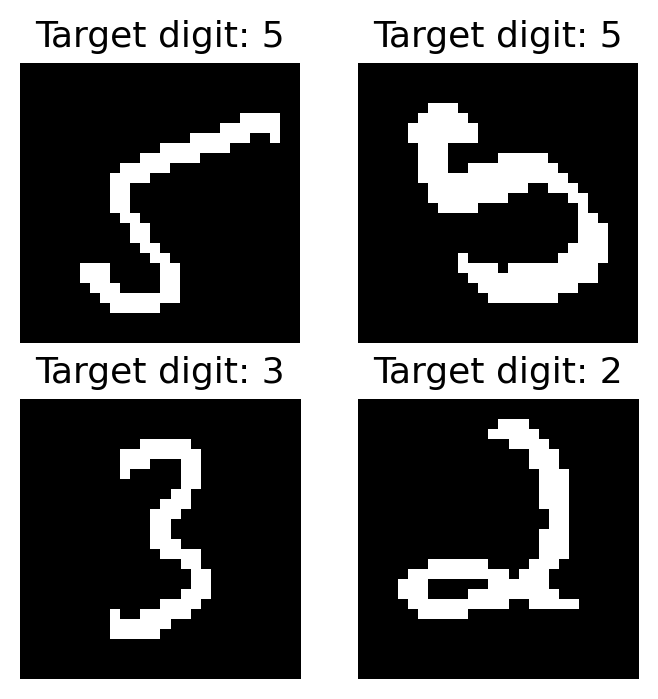

In [12]:
seed(314)
show_ix = choice(np.arange(len(y)), size=4, replace=False)
fig, ax = plt.subplots(2, 2, figsize=(4,4))
ax = ax.ravel()

for axi, ix in zip(ax, show_ix):
    axi.imshow(X[ix], cmap="bone")
    axi.set_title(f"Target digit: {y[ix]}", fontsize=13)
    axi.axis("off")

In [13]:
## Step 0: transform X into a matrix
k = 10
N, M1, M2 = X.shape
Xtr = X.reshape(N, -1)
Xtr.shape

(23352, 784)

In [14]:
mu_hist = []

## Step 1: initialize ∀k. pi_k, mu_k
seed(314)

pi = np.ones(k) / k
mu = uniform(low=0.25, high=0.75, size=(k, M1 * M2))
mu_hist.append(mu)

$$
    p({\bf x}_n|\boldsymbol \mu_k) = \prod_{d=1}^D \mu_{k,d}^{x_{n,d}}(1 - \mu_{k,d}) ^{1 - x_{n,d}} 
$$

$$\begin{array}{l l l}{{N_{k}}}&{{=}}&{{\displaystyle\sum_{n=1}^{N}\gamma(z_{n k})}}\\ {{\overline{{{\cal X}}}_{k}}}&{{=}}&{{\displaystyle\frac{1}{\displaystyle{{\cal N}}_{k}}\sum_{n=1}^{N}\gamma(z_{n k}){\sf x}_{n}}}\end{array}$$

In [15]:
%%time
for _ in range(25):
    Xtr_ = Xtr[:, np.newaxis, :]
    p_nk = (mu ** Xtr_ * (1 - mu) ** (1 - Xtr_) ) # 9.48

    gamma_nk = p_nk.prod(axis=-1) * pi
    gamma_nk = gamma_nk / gamma_nk.sum(axis=-1, keepdims=True) # 9.56

    Nk = gamma_nk.sum(axis=0) # 9.57

    mu = (Xtr_ * gamma_nk[..., np.newaxis]).sum(axis=0) / Nk[..., np.newaxis] # 9.58
    pi = Nk / N # 9.60
    mu_hist.append(mu)

CPU times: user 46.9 s, sys: 6.25 s, total: 53.1 s
Wall time: 53.3 s


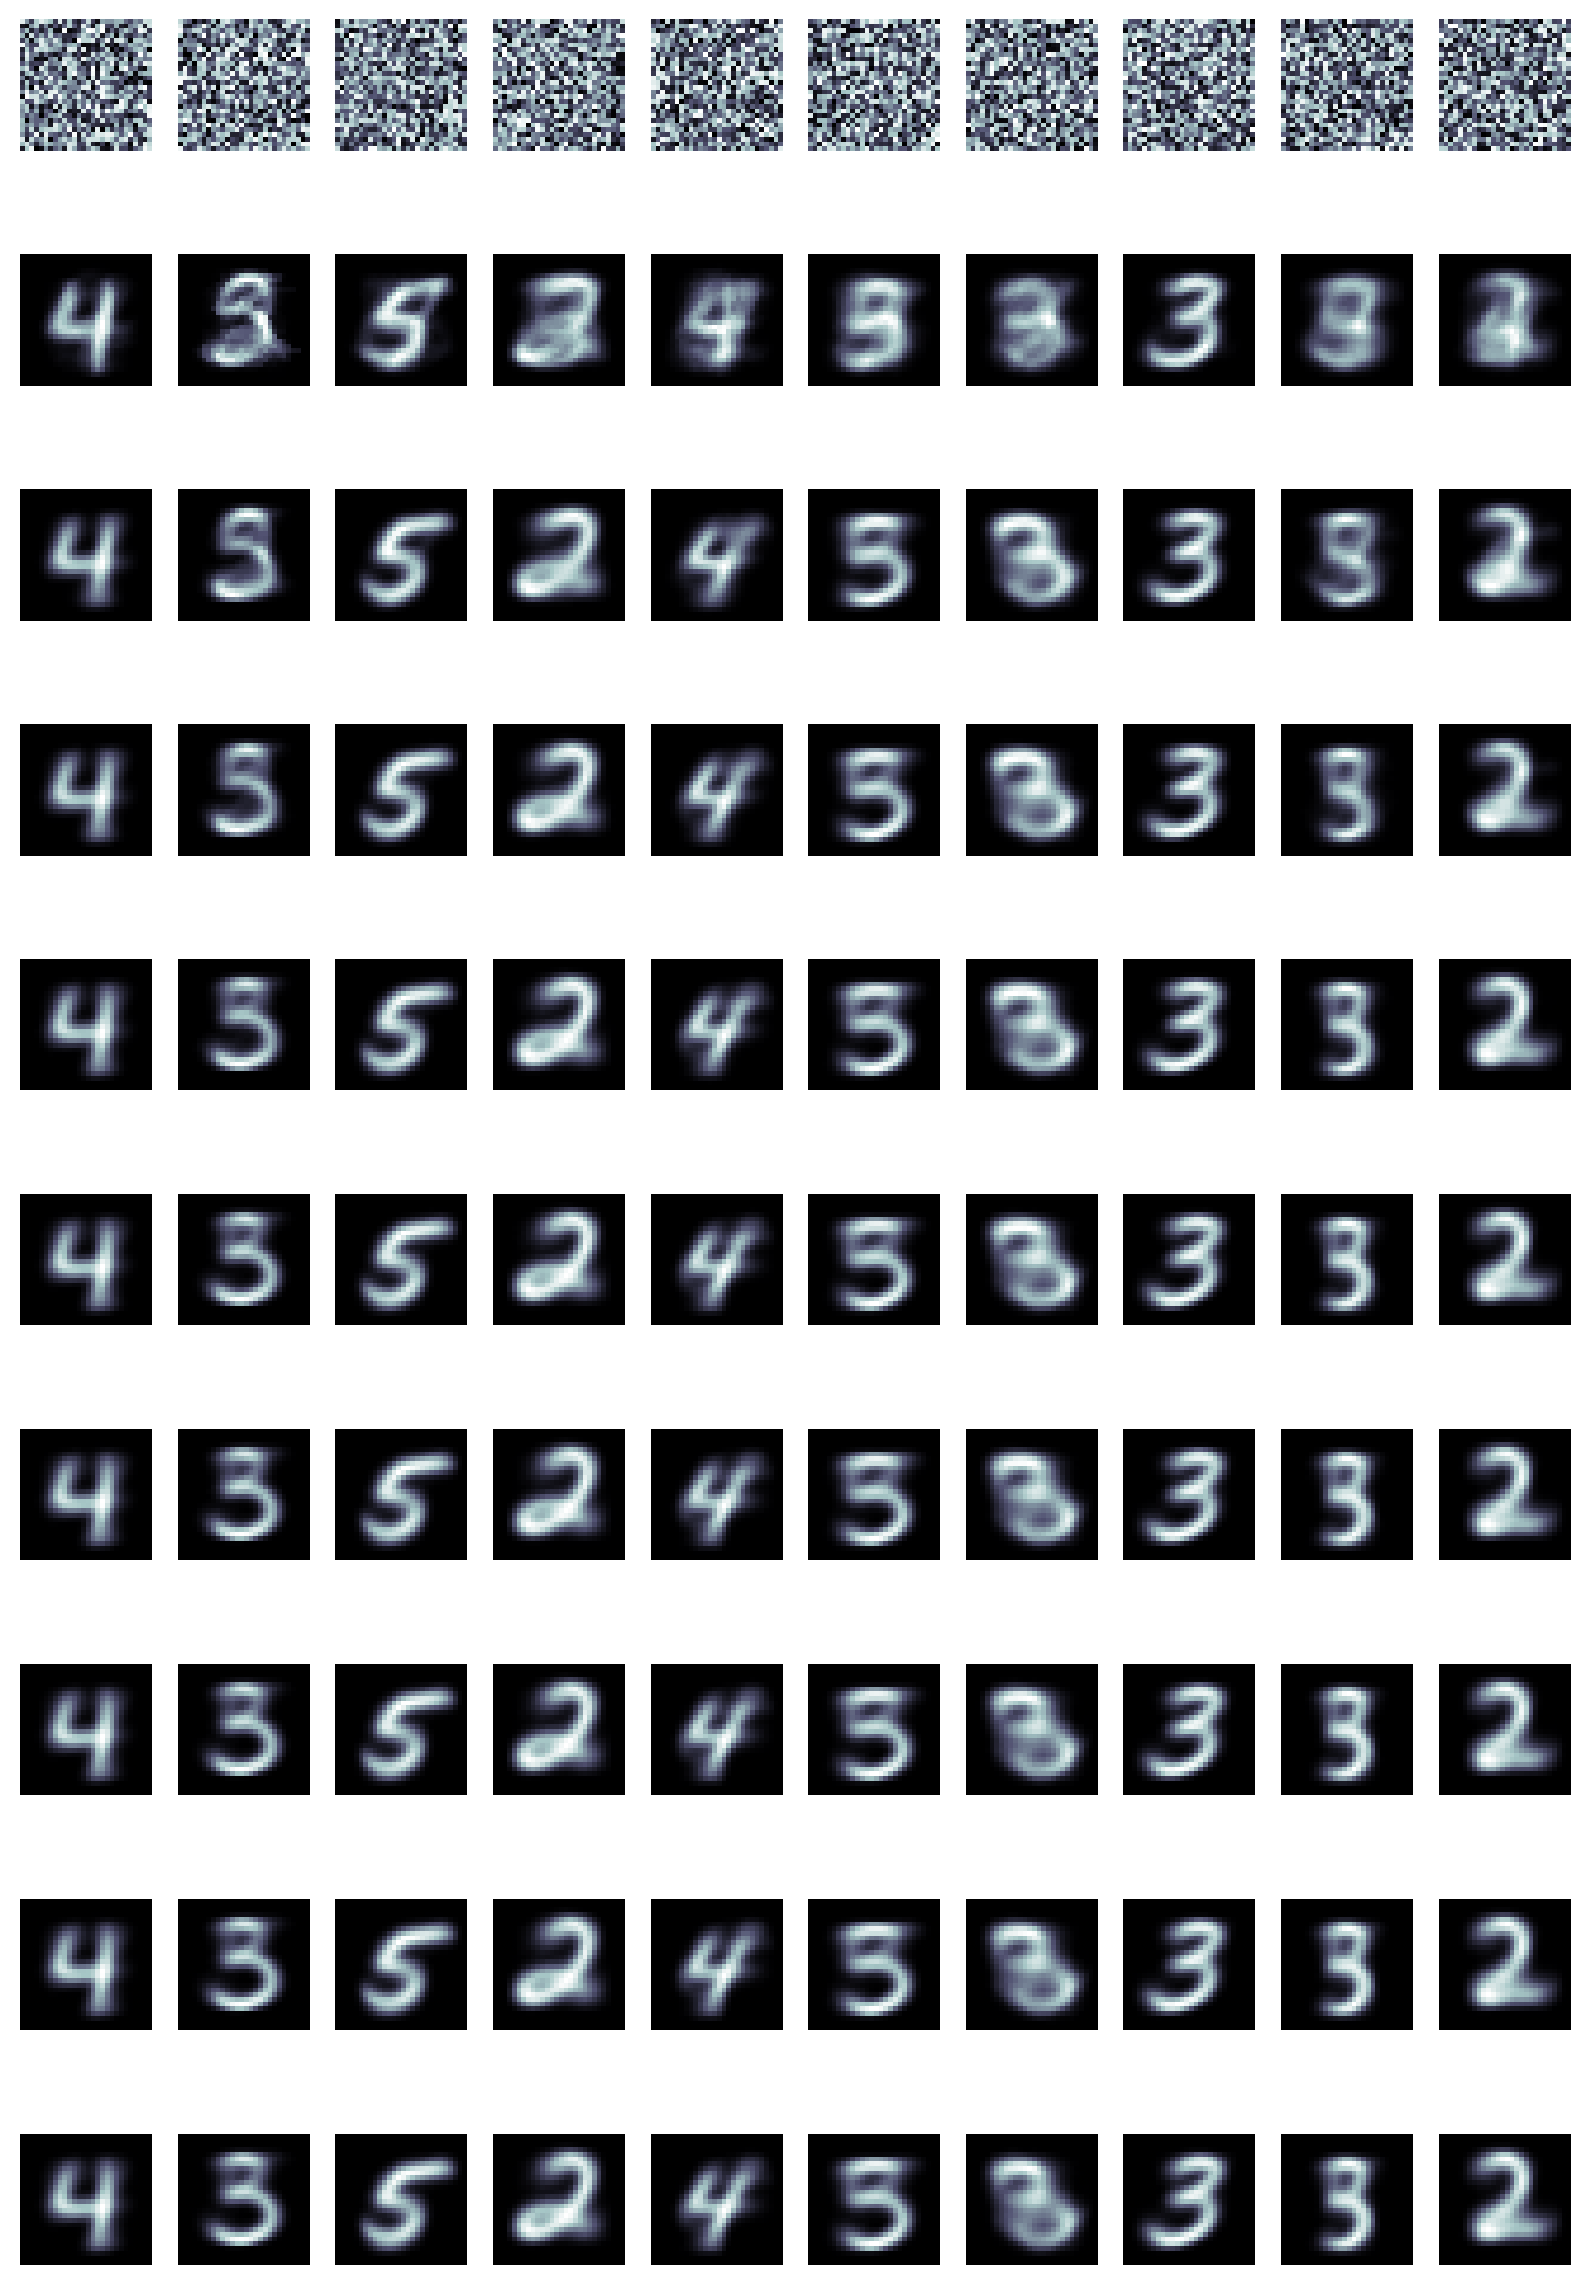

In [16]:
# Convergence of mean clusters
nsteps = 10 # plotting 10 steps towards convergence
fig, ax = plt.subplots(nsteps, k, figsize=(10, 15))
for m_i, ax_row in enumerate(ax):
    for ki, axi in enumerate(ax_row):
        axi.imshow(mu_hist[m_i][ki].reshape(M1, M2), cmap="bone")
        axi.axis("off");

## Animating Convergence

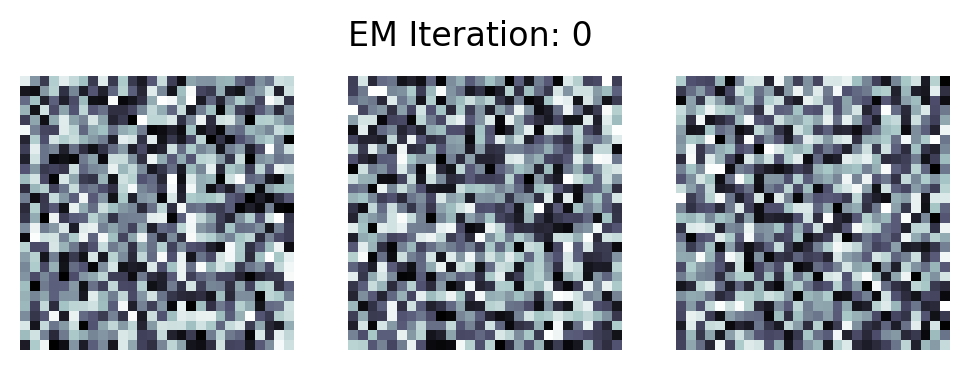

In [14]:
import matplotlib.animation as animation
fig, ax = plt.subplots(1, 3, figsize=(6, 2))

ki = -3
k1, k2, k3 = 0, -1, -3
def animate(i):
    #fig.clear()
    for axi, ki in zip(ax, [k1, k2, k3]):
        axi.cla()
        mu_ki = mu_hist[i][ki]
        axi.imshow(mu_ki.reshape(M1, M2), cmap="bone")
        axi.axis("off")
    plt.suptitle(f"EM Iteration: {i}")

nits = len(mu_hist)
ani = animation.FuncAnimation(fig, animate, nits, interval=300)
ani.save("./bern.gif", fps=9, dpi=150, writer="imagemagick")

In [17]:
from IPython.display import display, Math

# Render the formula E = mc^2
display(Math(r"E = mc^2"))


<IPython.core.display.Math object>